<a href="https://colab.research.google.com/github/kelseyneis/horoscope-mining/blob/main/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 5523 Final project
Mohammed Guiga, Kelsey Neis, Sai Sharan Sundar, Josh Spitzer-Resnick

## imports

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for reading csv in Colab
# from google.colab import files
# uploaded = files.upload() # if first time uncomment this and manually load in data # use chrome not firefox, not incognito
# import io

# exploratory analysis
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet') # get_lemmas
nltk.download('punkt') # nltk.word_tokenize in get_lemmas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [98]:
# If wordcloud has errors, run these lines and restart the kernel
# !pip install --upgrade pip
# !pip install --upgrade wordcloud

In [99]:
# df = pd.read_csv( io.BytesIO(uploaded['horoscope_saved.csv']) ) # nrows = 100. Use with Google Colab
df = pd.read_csv("../horoscope_saved.csv")
# horoscopes = np.genfromtxt(io.BytesIO(uploaded['horoscope_saved.csv']), delimiter = ',', max_rows = 100)

## exploratory data analysis

### word count visualizations

In [100]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [101]:
from nltk.tokenize import RegexpTokenizer
def adj_cloud(sign):
    pos_tags = []
    scorpio = df[(df['category'] == 'general') & (df['sign'] == sign)]['horoscope']

    tokenizer = RegexpTokenizer(r'\w+')

    for horoscope in scorpio:
        tokens = tokenizer.tokenize(horoscope)
        for token in tokens:
            pos_tags.append(token)
        
    scorpio_tags = nltk.pos_tag(pos_tags)
    scorpio_adj = [t[0] for t in scorpio_tags if t[1] == "JJ"]
    stop_words = text.ENGLISH_STOP_WORDS.union(['don', 'make', 'isn', 'new', 'good', 'll', 've'])
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    vecs = vectorizer.fit_transform(scorpio)

    feature_names = vectorizer.get_feature_names()
    dense = vecs.todense()
    lst1 = dense.tolist()
    lst1_adj = []

    feature_adj_bool = np.zeros(len(feature_names), dtype=bool)
    for i in range(len(feature_names)):
        for x in scorpio_adj:
            if x == feature_names[i]:
                feature_adj_bool[i] = True
            
    feature_adj = []


    for i in range(len(lst1)):
        lst1_adj.append([lst1[i][x] for x in range(len(lst1[i])) if feature_adj_bool[x] == True])

    for j in range(len(feature_names)):
        if feature_adj_bool[j] == True:
            feature_adj.append(feature_names[j])

    cloud_df = pd.DataFrame(lst1_adj, columns=feature_adj)

    drop_cols = [x for x in feature_adj if max(cloud_df[x]) < .35]
    cloud_df = cloud_df.drop(columns=drop_cols)

    Cloud = WordCloud(background_color="black", max_words=100) \
        .generate_from_frequencies(cloud_df.T.sum(axis=1))

    plt.imshow(Cloud)
    plt.axis('off')
    plt.title(sign, fontsize = 20)
    plt.show()

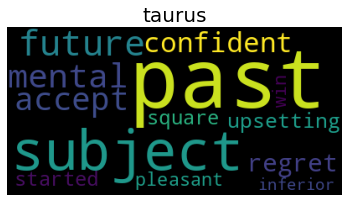

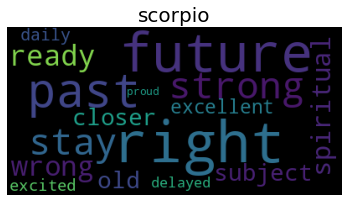

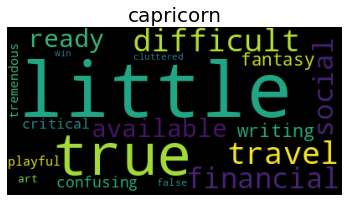

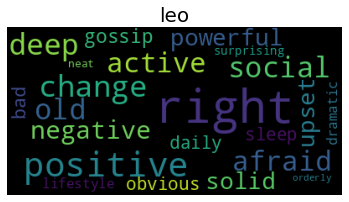

In [102]:
adj_cloud('taurus')
adj_cloud('scorpio')
adj_cloud('capricorn')
adj_cloud('leo')
